# Snorkel LinTo 

### Contents
#### 1. Data loading
#### 2. Label definition
#### 3. Train/test/dev sets separation
#### 4. Rules writing
#### 5. Application of the rules
#### 6. Generative model
#### 7. Analysis of the results
#### 8. Useful files creation


## 1. Data loading

In [1]:
%matplotlib inline
import os
import numpy as np

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"


In [2]:
import pandas as pd


DISPLAY_ALL_TEXT = True

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)



In [3]:

import spacy

nlp = spacy.load('fr_core_news_sm')

# if not loaded : french model
#! python -m spacy download fr_core_news_sm

In [4]:
# Complete dataframe loading with columns : 
#['word', 'beg_word', 'end_word', 'n_turn', 'beg_turn', 'end_turn',
 #      'rank_turn', 'text_turn', 'sil_bef', 'sil_aft', 'tony',
  #     'tony_realturns', 'gold', 'prob_nothing', 'prob_period', 'prob_comma',
   #    'prob_nothing_bef', 'prob_period_bef', 'prob_comma_bef',
    #   'real_rank_turn', 'pitch', 'energy', 'pitch_bef', 'energy_bef', 'punct',
     #  'punct_bef', 'file', 'token', 'token_bef', 'token_aft', 'dep',
      # 'dep_bef', 'dep_aft', 'headpos', 'headpos_bef', 'headpos_aft',
       #'energy_aft', 'pitch_aft']

df_linto = pd.read_csv("../data/df_all_final_LinTo_23032021.csv")
df_linto.head()

,word,beg_word,end_word,n_turn,beg_turn,end_turn,rank_turn,text_turn,sil_bef,sil_aft,...,token_bef,token_aft,dep,dep_bef,dep_aft,headpos,headpos_bef,headpos_aft,energy_aft,pitch_aft
0,ok,2.00,2.37,0,0.0,10.123,0,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,1.26,0.00,...,ADP,ADV,ROOT,ROOT,advmod,ADP,ADP,ADP,0,0
1,donc,2.73,3.01,0,0.0,10.123,1,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.24,...,ADP,ADV,advmod,ROOT,advmod,ADP,ADP,VERB,D,U
2,juste,3.38,3.67,0,0.0,10.123,2,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.24,0.00,...,ADV,SCONJ,advmod,advmod,mark,VERB,ADP,VERB,D,D
3,comme,3.92,4.22,0,0.0,10.123,3,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.00,...,ADV,PRON,mark,advmod,nsubj,VERB,VERB,VERB,U,D
4,on,4.23,4.67,0,0.0,10.123,4,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.12,...,SCONJ,VERB,nsubj,mark,xcomp,VERB,VERB,ADP,D,U


In [5]:
df_linto.columns

Index(['word', 'beg_word', 'end_word', 'n_turn', 'beg_turn', 'end_turn',
       'rank_turn', 'text_turn', 'sil_bef', 'sil_aft', 'tony',
       'tony_realturns', 'gold', 'prob_nothing', 'prob_period', 'prob_comma',
       'prob_nothing_bef', 'prob_period_bef', 'prob_comma_bef',
       'real_rank_turn', 'pitch', 'energy', 'pitch_bef', 'energy_bef', 'punct',
       'punct_bef', 'file', 'token', 'token_bef', 'token_aft', 'dep',
       'dep_bef', 'dep_aft', 'headpos', 'headpos_bef', 'headpos_aft',
       'energy_aft', 'pitch_aft'],
      dtype='object')

In [6]:
# to-do : check if every columns are presents in the loaded file

## 2. Label definition

In [7]:
ABSTAIN = -1
NO = 0
BOS = 1

## 3. Train/test/dev sets separation

In [8]:
df_dev = df_linto[(df_linto["file"]=="Linagora_R1") | (df_linto["file"]=="Linagora_A1")]
df_test = df_linto[(df_linto["file"]=="Linagora_P1") | (df_linto["file"]=="Linagora_C1")]
df_train=df_linto[(df_linto["file"]!="Linagora_R1")&(df_linto["file"]!="Linagora_A1")&(df_linto["file"]!="Linagora_P1")&(df_linto["file"]!="Linagora_C1")]


Y_test = df_test["gold"].values
Y_dev = df_dev["gold"].values

print("dev length = ", len(df_dev),"words \ntest length = ", len(df_test),"words \ntrain length = ", len(df_train), "words")

dev length =  9752 words 
test length =  8833 words 
train length =  53692 words


## 4. Rules writing

In [9]:

import sys
sys.path.insert(1,"utils/")
from utils_snorkel_linto import * 

beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
couple_markers=dict(du=["coup"], de=["fait"], en=["fait", "vrai", "effet"], parce=["que","qu'"], et=["puis", "donc"],enfin=["bon"],mais=["bon"], à=["propos"], tu=["vois","sais"])
single_markers=["ouais", "donc","effectivement","alors","bref","voilà", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils","qui", "que", "j'","c'"]

### Basic rules (without preprocessor)



In [10]:
from snorkel.labeling import labeling_function


# If ToNy (written) predicts BOS -> BOS
@labeling_function()
def tony(x):
    return BOS if x["tony"]==1 else ABSTAIN


# If period likelihood just before the current word > 0.3 -> BOS 
@labeling_function()
def period_bef(x):
    return BOS if x["prob_period_bef"]>0.3 and x["word"]!="euh" else ABSTAIN

# If no punctuation likelihood after the current word > 0.99 -> NO
@labeling_function()
def nothing_bef(x):
    return NO if x["prob_nothing_bef"]>0.99 else ABSTAIN

# If comma likelihood just before the current word > 0.3 -> BOS
@labeling_function()
def comma_bef(x):
     return BOS if x["prob_comma_bef"]>0.3 else ABSTAIN


# If repetitions/hesitations ("euh" aside) -> NO
@labeling_function()
def no_disfluency(x):
    param_context=4
    list_text=str(x["text_turn"]).split(" ")
    pos=int(x["rank_turn"])
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        while "euh" in context:
            context.remove("euh")
            cmpt+=1
        if abs(len(set(context))-len(context))>=2 or cmpt>2:
            return NO
        
    param_context=2
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        if len(set(context))!=len(context):
            return NO
    return ABSTAIN

# If energy and pitch follow a particular pattern -> BOS
@labeling_function()
def energy_pitch(x):
    liste_features=["DUUS", "DDUS", "DDUU", "SDUD", "SUUD", "SUUU"]
    str_feat=str(x.energy_bef)+str(x.energy)+str(x.pitch_bef)+str(x.pitch)
    
    if str_feat in liste_features and x.word!="euh" and x.sil_bef>0.3:
        return BOS

    return ABSTAIN






# If previous, current and next word belongs to specific types -> BOS 
@labeling_function()
def cconj(x):
    liste_no=["euh", "pas", "que", "ou", "tu", "aussi", "là"]
    if (x.token_bef=="NOUN" and  x.token=="CCONJ" and x.token_aft=="PRON") or (x.token_bef=="NOUN" and  x.token=="SCONJ" and x.token_aft=="SCONJ") or (x.token_bef=="NOUN" and  x.token=="ADV" and x.token_aft=="PRON") and x.word not in liste_no:
        return BOS
    return ABSTAIN


# if beginning of real turn -> BOS
@labeling_function()
def beg_real_turn(x):
    if x.real_rank_turn==0:
        return BOS
    return ABSTAIN


### Rules using preprocessor

#### Preprocessor creation

In [11]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="word",language='fr_core_news_sm', doc_field="doc", memoize=True)


In [12]:
import numpy as np
from snorkel.preprocess import preprocessor


@preprocessor(memoize=True)
def word_context_markers(x):
    text_list=str(x.text_turn).split(" ")
    position=int(x.rank_turn)
    
    x.word_aft,x.word_bef = get_word_context(text_list, position)
    x.first_marker=set_first_marker(couple_markers, single_markers, text_list, position, x.word)
    x.after_marker=set_after_marker(couple_markers, single_markers, text_list, position, x.word)
    
    return x

#### Pre-processor : word_context_markers

In [13]:
# If current word is an isolated marker or ther first of a serie -> BOS
@labeling_function(pre=[word_context_markers])
def first_marker(x):
    if x.first_marker==1:
        return BOS
    else:
        return ABSTAIN

In [14]:
# If the current word follows an isolated marker or a serie of markers -> NO
@labeling_function(pre=[word_context_markers])
def no_after_markers(x):
    if x.after_marker==1:
        return NO
    else:
        return ABSTAIN

    
# If energy/f0 follow a specific pattern -> NO
@labeling_function(pre=[word_context_markers])
def no_energy_pitch(x):
    list_nrj_bef=["S", "U"]
    list_pitch_bef=["D", "S"]
    if (x.energy_bef in list_nrj_bef and x.pitch_bef in list_pitch_bef)or  (x.energy_bef=="D" and x.energy=="D"):
        if x.first_marker!=1 and x.word not in pronoms:
            return NO
    return ABSTAIN



# If silence longer than 0.7s before the word -> BOS

@labeling_function(pre=[word_context_markers])
def sil_bef(x):
    
    if x.after_marker!=1 and x["sil_bef"]>=0.7 and x.word_bef!="euh" and x.word_aft!="euh" and x.word_bef!=x.word_aft and x.word_bef!=x["word"] and x.word_aft!=x["word"] and x["word"]!="euh":
        single_markers=["donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
        pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils"]
        
        return BOS


    return ABSTAIN



# If no silence before the word -> NO
@labeling_function(pre=[word_context_markers])
def no_sil_bef(x):
    if x["sil_bef"]==0 and x.first_marker!=1 and x["word"] not in pronoms:
        return NO
    else:
        return ABSTAIN

# If word in keyword list -> BOS
@labeling_function(pre=[word_context_markers])
def keywords(x):
    liste=["bonjour", "merci", "ok", "oui", "non", "ouais"]
    if x.after_marker!=1:
        if x.word in liste or (x.word=="d'" and x.word_aft=="accord") or (x.word=="hum" and x.word_aft=="hum"):
            return BOS 
    return ABSTAIN


# If combination of audio and spacy info are successful in dev set

@labeling_function(pre=[word_context_markers])
def spacy_audio_combinations(x):
    # dictionary of godd BOS combinations between part-of-speech informaiton and pitch/energy/dependency/pos of head dependency
    # P = previous, C = Current
    
    # example : dict_PC_PCe
    # means it's a dictionary with the pos-tags of the Previous and Current (PC) words  
    # combined to the energy orientation of previous and current words (PCe)
    
    # the combinations with BOS proportion>50% have been selected and put in the dictionaries
    
    dict_PC_PCe,dict_PC_PCp,dict_PC_PCpe,dict_PC_Cdep,dict_PC_Cheadpos,dict_PC_Pheadpos, dict_PC_Pdep = get_dictionaries_spacy_audio()
    
    # get spacy and audio  information of Previous and Current words to compare with dict
    PCpos=x.token_bef+"_"+x.token
    Cdep=x.dep
    Cheadpos=x.headpos
    Pdep=x.dep_bef
    Pheadpos=x.headpos_bef
    PCe=str(x.energy_bef)+str(x.energy)
    PCp=str(x.pitch_bef)+str(x.pitch)
    PCp_PCe=str(x.pitch_bef)+str(x.pitch)+"_"+str(x.energy_bef)+str(x.energy)
    
    cmpt=0             
    if x.after_marker!=1:
        if PCpos in dict_PC_PCe.keys() and PCe in dict_PC_PCe[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_PCp.keys() and PCp in dict_PC_PCp[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_PCpe.keys() and PCp_PCe in dict_PC_PCpe[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Cdep.keys() and Cdep in dict_PC_Cdep[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Pdep.keys() and Pdep in dict_PC_Pdep[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Pheadpos.keys() and Pheadpos in dict_PC_Pheadpos[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Cheadpos.keys() and Cheadpos in dict_PC_Cheadpos[PCpos]:
            cmpt+=1
    # if word belongs to 4 combinations at least : BOS 
        if cmpt>=4: 
            return BOS
    
    return ABSTAIN
    


# If ToNy detects a Segment -> Begin of Segment (BOS)
@labeling_function(pre=[word_context_markers])
def tony_realturns(x):
   # if x.word in beg_markers and x["tony_realturns"]==1 and x.first_marker!=1:
    #    return ABSTAIN
    #elif x["tony_realturns"]==1 and x.after_marker!=1:
    #    return BOS 
    if x.tony_realturns==1:
        return BOS
    return ABSTAIN

#### Pre-processor : spacy

In [15]:
# If word is a specific type -> NO
@labeling_function(pre=[spacy])
def no_type(x):
    """Ham comments mention specific people and are short."""
    if  any([(token.pos_ == "ADJ" or token.pos_ == "DET" or token.pos_ == "AUX" or token.pos_ == "VERB") for token in x.doc]) :
        return NO
    else:
        return ABSTAIN



## 5. Application of the rules on the 3 sets

In [17]:
from snorkel.labeling import PandasLFApplier
# list of rules wanted to annotate the corpus
lfs=[ cconj, tony_realturns, first_marker,  no_type, no_sil_bef, no_after_markers, no_disfluency,
     period_bef, keywords, nothing_bef, spacy_audio_combinations, beg_real_turn]



applier = PandasLFApplier(lfs=lfs)
L_dev = applier.apply(df=df_dev)
L_test = applier.apply(df=df_test)
L_train = applier.apply(df=df_train)

/users/linto/lgravell/.conda/envs/linto/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 53692/53692 [04:32<00:00, 197.38it/s]


### Coverage evaluation

In [18]:
coverage = (L_train != ABSTAIN).mean(axis=0)
i=0
for score in list(coverage):
    print(lfs[i], f"coverage: {score * 100:.1f}%")
    i+=1


LabelingFunction cconj, Preprocessors: [] coverage: 0.9%
LabelingFunction tony_realturns, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 11.9%
LabelingFunction first_marker, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 4.5%
LabelingFunction no_type, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []] coverage: 34.5%
LabelingFunction no_sil_bef, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 66.5%
LabelingFunction no_after_markers, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 6.7%
LabelingFunction no_disfluency, Preprocessors: [] coverage: 17.5%
LabelingFunction period_bef, Preprocessors: [] coverage: 6.7%
LabelingFunction keywords, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 1.8%
LabelingFunction nothing_bef, Preprocessors: [] coverage: 49.6%
LabelingFunction spacy_audio_combinations, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 3.

### L_train observation

In [19]:
# train summary 
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
cconj,0,[1],0.009424,0.009257,0.002868
tony_realturns,1,[1],0.118807,0.100499,0.052559
first_marker,2,[1],0.044588,0.037361,0.014416
no_type,3,[0],0.344763,0.329248,0.022704
no_sil_bef,4,[0],0.665500,0.560903,0.045240
no_after_markers,5,[0],0.066602,0.051367,0.006835
no_disfluency,6,[0],0.175147,0.155759,0.027565
period_bef,7,[1],0.066565,0.059711,0.026503
keywords,8,[1],0.017675,0.017284,0.012907
nothing_bef,9,[0],0.495772,0.453494,0.006556


In [20]:
print(LFAnalysis(L=L_train, lfs=lfs).lf_summary())

                           j Polarity  Coverage  Overlaps  Conflicts
cconj                     0   [1]      0.009424  0.009257  0.002868 
tony_realturns            1   [1]      0.118807  0.100499  0.052559 
first_marker              2   [1]      0.044588  0.037361  0.014416 
no_type                   3   [0]      0.344763  0.329248  0.022704 
no_sil_bef                4   [0]      0.665500  0.560903  0.045240 
no_after_markers          5   [0]      0.066602  0.051367  0.006835 
no_disfluency             6   [0]      0.175147  0.155759  0.027565 
period_bef                7   [1]      0.066565  0.059711  0.026503 
keywords                  8   [1]      0.017675  0.017284  0.012907 
nothing_bef               9   [0]      0.495772  0.453494  0.006556 
spacy_audio_combinations  10  [1]      0.031606  0.029017  0.012311 
beg_real_turn             11  [1]      0.039820  0.039764  0.021027 


### Analysis of the rules on dev set

In [83]:
# dev summary 
from snorkel.labeling import LFAnalysis
dev_rules_results=LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y_dev)
dev_rules_results

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
cconj,0,[1],0.008203,0.008101,0.002461,71,9,0.887500
tony_realturns,1,[1],0.111874,0.096903,0.047888,817,274,0.748854
first_marker,2,[1],0.051169,0.042350,0.016817,338,161,0.677355
no_type,3,[0],0.331317,0.315217,0.020816,3108,123,0.961931
no_sil_bef,4,[0],0.624180,0.521637,0.033634,5884,203,0.966650
no_after_markers,5,[0],0.074754,0.058039,0.007486,686,43,0.941015
no_disfluency,6,[0],0.235747,0.206624,0.033532,2121,178,0.922575
period_bef,7,[1],0.064705,0.058552,0.024713,449,182,0.711569
keywords,8,[1],0.015279,0.015074,0.011280,88,61,0.590604
nothing_bef,9,[0],0.475185,0.427605,0.005435,4618,16,0.996547


### BOS rules score

In [50]:
s1=Y_dev.sum() # N of positive points
s0=len(Y_dev)-s1 

rule=[]
p=[]
r=[]
fscore=[]
rule=[]

for x in a.itertuples():
    if x.Polarity==[1]:
        # precision = TP / (TP + FP ) 
        precision=int(x.Correct)/(int(x.Correct)+int(x.Incorrect))
        p.append(precision)
        # recall = TP /(TP + FN )
        recall=(x.Correct)/(int(x.Correct)+(int(s1-x.Correct)))
        r.append(recall)
        # fscore= 2.(p.r / (p+r))
        fscore.append(2*precision*recall/(precision+recall))
        rule.append(x.Index)

df_scores=pd.DataFrame({'rule': rule, 'precision': p, 'recall': r, 'fscore': fscore})
df_scores

,rule,precision,recall,fscore
0,cconj,0.887500,0.062281,0.116393
1,tony_realturns,0.748854,0.716667,0.732407
2,first_marker,0.677355,0.296491,0.412447
3,period_bef,0.711569,0.393860,0.507058
4,keywords,0.590604,0.077193,0.136540
5,spacy_audio_combinations,0.752212,0.223684,0.344828
6,beg_real_turn,0.986755,0.261404,0.413315


## 6. Generative Model

### Generative model creation

In [69]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_dev = majority_model.predict(L=L_train)

In [70]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train,Y_dev=Y_dev, n_epochs=7000, seed=123)


In [71]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   89.3%
Label Model Accuracy:     91.1%


### Evaluation of the generative model's output

In [72]:
# dev 
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}",
    f"Label model precision score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='precision')}",
    f"Label model recall score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}",
    sep = "\n"
)

Label model f1 score: 0.6889279437609842
Label model precision score: 0.6901408450704225
Label model recall score: 0.6877192982456141
Label model roc-auc: 0.9269482199460566


In [73]:
# test
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
probs_test = label_model.predict_proba(L_test)
preds_test = probs_to_preds(probs_test)
print(
    f"Label model f1 score: {metric_score(Y_test, preds_test, probs=probs_test, metric='f1')}",
    f"Label model precision score: {metric_score(Y_test, preds_test, probs=probs_test, metric='precision')}",
    f"Label model recall score: {metric_score(Y_test, preds_test, probs=probs_test, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_test, preds_test, probs=probs_test, metric='roc_auc')}",
    sep = "\n"
)

Label model f1 score: 0.6447249774571687
Label model precision score: 0.6595940959409594
Label model recall score: 0.6305114638447972
Label model roc-auc: 0.9186997303527588


### Threshold settings

<class 'numpy.ndarray'>
0.1941941941941942


/users/linto/lgravell/.conda/envs/linto/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


Text(0, 0.5, 'fscore of generative model')

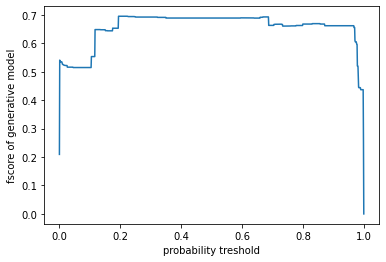

In [89]:
#calcul seuil
print(type(preds_dev))

label=[]
for Ve in probs_dev:
    if  e[1]>0.194:
        label.append(1)
    else:
        label.append(0)
preds_dev=np.array(label)

f1=[]
tresh_list=np.linspace(0,1,1000)
label=[]
for t in tresh_list:
    label=[]
    for e in probs_dev:
        if  e[1]>t:
            label.append(1)
        else:
            label.append(0)
            
    preds_dev=np.array(label)
    f1.append(metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1'))
    
import matplotlib.pyplot as plt

print(tresh_list[np.argmax(f1)])
treshold= tresh_list[np.argmax(f1)]
plt.plot(e1_list, f1)
plt.xlabel('probability treshold')
plt.ylabel('fscore of generative model')

### Segeval evaluation

In [85]:
import segeval as se

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>treshold:
        label.append(1)
    else:
        label.append(0)
tony_list=[]       
for x in df_dev.itertuples():
    tony_list.append(x.tony_realturns)

#print(len(Y_dev), len(label))
gold_nltk=""
result_nltk=""
tony_nltk=""


for i in range(0,len(Y_dev)):
    gold_nltk+=str(Y_dev[i])
    result_nltk+=str(label[i])
    tony_nltk+=str(tony_list[i])

#print(len(gold_str), len(result_str))
gold_masses=se.convert_nltk_to_masses(gold_nltk, boundary_symbol='1')
result_masses=se.convert_nltk_to_masses(result_nltk, boundary_symbol='1')
tony_masses=se.convert_nltk_to_masses(tony_nltk, boundary_symbol='1')
nt=2
print("Boundary Similarity = ", se.boundary_similarity(gold_masses, result_masses, n_t=nt))
print("Boundary Similarity tony alone = ", se.boundary_similarity(gold_masses, tony_masses, n_t=nt))

gold_str=se.boundary_string_from_masses(gold_masses)
result_str=se.boundary_string_from_masses(result_masses)

edit_distance=se.boundary_edit_distance(gold_str, result_str,3)
#convert_masses_to_positions(masses)
gold_positions=se.convert_masses_to_positions(gold_masses)
result_positions=se.convert_masses_to_positions(result_masses)


print("Segmentation Similarity = ",se.segmentation_similarity(gold_masses, result_masses))


# Cross Entropy
from math import *

ec=0
for i in range(0, len(probs_dev)):
    ec+=log(probs_dev[i][1])*label[i]
    
ec=-ec/len(probs_dev)

print("Cross Entropy = ", ec)

Boundary Similarity =  0.5429447852760736196319018405
Boundary Similarity tony alone =  0.5971922246220302375809935205
Segmentation Similarity =  0.9312448728465955701394585726
entropie croisée =  0.01727750023786382


## 7. Analysis of the results

### Label distribution on the corpus

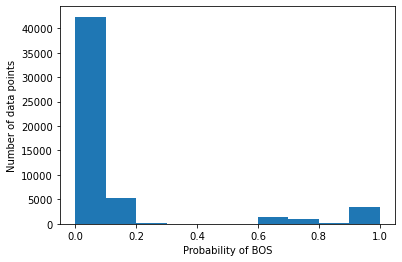

In [76]:
np.around(label_model.get_weights(), 2) 
import matplotlib.pyplot as plt


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of BOS")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, BOS])

### Weights of the rules 

In [77]:
np.around(label_model.get_weights(), 2) 

array([0.86, 0.73, 0.7 , 1.  , 1.  , 0.66, 0.87, 0.77, 0.77, 1.  , 0.69,
       0.98])

### Number of labels for data points

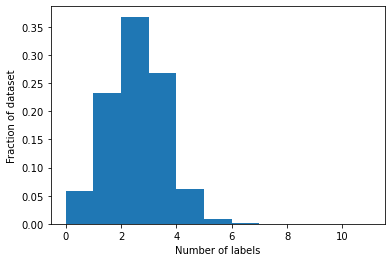

In [78]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## 8. Useful files creation

1.File for training anf fine-tuning of ToNy system
<br>
2.Visualization file of BOS inside the text
<br>

### 1. File for training anf fine-tuning of ToNy system

In [79]:
treshold=tresh_list[np.argmax(f1)]
print(treshold)

# change the date
date="26032021"

probs_train = label_model.predict_proba(L_train)

# label separation 

label_train=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>treshold:
        label_train.append(1)
    else:
        label_train.append(0)
        

0.1941941941941942


In [80]:
#file creation
# TRAIN

file_tony=open("file_train_tony_"+date+".txt", "w")
i=0

for x in df_train.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if label_train[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1
file_tony.close()



In [248]:

# DEV 

file_tony=open("file_gold_dev_tony.txt", "w")
i=0

for x in df_dev.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if Y_dev[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1

file_tony.close()

# TEST

file_tony=open("file_gold_test_tony.txt", "w")
i=0

for x in df_test.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if Y_test[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1

file_tony.close()

### 2.Fichier de visualisation des BOS de sortie du modèle génératif , comparaison avec le GOLD

In [87]:
# creation of a readable file to see if it qualitatively works 


label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>treshold:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("readable_bos_output_generative_model_"+date+".txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_turn==0 :
        if x.prob_period_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk---"+"\n"+"\n")

    if label[i]==1:
        liste_texte.append("|D|")
    if Y_dev[i]==1:
        liste_texte.append("|G|")      
    
    
    if x.prob_period_bef>0.5 or x.real_rank_turn==0:
        mot=str(mot).capitalize()
    
    if x.prob_period>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()
    